# Лабораторная работа 3 Краевая задачу для дифференциального уравнения эллиптического типа.
## Методы простых итераций, простых итераций с верхней релаксацией, Зейделя
## Син Д.Д.  М8О-407Б-18

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
def ux0(y):
    return np.cos(y)


def uxl(y):
    return np.e * np.cos(y)


def uy0(x):
    return 0


def uyl(x):
    return -np.exp(x)


def U(x, y):
    return np.exp(x) * np.cos(y)


X_MAX = 1
Y_MAX = np.pi / 2
MAX_ITER = 10000

In [3]:
def simple_iter(hx, hy, eps, verbose=False):
    x = np.arange(0, X_MAX + hx, hx)
    y = np.arange(0, Y_MAX + hy, hy)
    cur = np.zeros((x.size, y.size))
    cur[0] = ux0(y)
    cur[-1] = uxl(y)
    for j in range(y.size):
        for i in range(1, x.size-1):
            cur[i][j] = cur[i][0] + (cur[i][-1] - cur[i][0]) / (x[-1] - x[0]) * (x[i] - x[0])
            
    norms = []
    for it in range(MAX_ITER):
        prev = cur.copy()
        for i in range(1, x.size - 1):
            for j in range(1, y.size - 1):
                cur[i][j] = (hx**2 * (prev[i-1][j] + prev[i+1][j]) +
                             hy**2 * (prev[i][j-1] + prev[i][j+1])) / (2 * (hx**2 + hy**2))
        cur[:,0] = cur[:,1] - hy * uy0(x)
        cur[:,-1] = cur[:,-2] + hy * uyl(x)
        norm = np.linalg.norm(cur - prev, np.inf)
        norms.append(norm)
        if verbose:
            print('iter', it, 'norma', norm)
        if (norm <= eps):
            break
    return cur, np.array(norms)

In [4]:
def relax_method(hx, hy, eps, w=1.8, verbose=False):
    x = np.arange(0, X_MAX + hx, hx)
    y = np.arange(0, Y_MAX + hy, hy)
    cur = np.zeros((x.size, y.size))
    cur[0] = ux0(y)
    cur[-1] = uxl(y)
    for j in range(y.size):
        for i in range(1, x.size-1):
            cur[i][j] = cur[i][0] + (cur[i][-1] - cur[i][0]) / (x[-1] - x[0]) * (x[i] - x[0])
    norms = []
    for it in range(MAX_ITER):
        prev = cur.copy()
        for i in range(1, x.size - 1):
            for j in range(1, y.size - 1):
                cur[i][j] = (hx**2 * (cur[i-1][j] + prev[i+1][j]) + hy**2 * (cur[i][j-1] + prev[i][j+1])) / (2 * (hx**2 + hy**2))
                cur[i][j] *= w
                cur[i][j] += (1-w) * prev[i][j]
        cur[:,0] = cur[:,1] - hy * uy0(x)
        cur[:,-1] = cur[:,-2] + hy * uyl(x)
        norm = np.linalg.norm(cur - prev, np.inf)
        norms.append(norm)
        if verbose:
            print('iter', it, 'norma', norm)
        if (norm <= eps):
            break
    return cur, np.array(norms)

In [5]:
def zeidel_method(hx, hy, eps, verbose=False):
    return relax_method(hx, hy, eps, 1, verbose)

In [6]:
def analytic(hx, hy):
    x = np.arange(0, X_MAX + hx, hx)
    y = np.arange(0, Y_MAX + hy, hy)
    u = np.zeros((x.size, y.size))
    for i in range(x.size):
        for j in range(y.size):
            u[i][j] = U(x[i], y[j])
    return u

In [7]:
solvers = {
    'simple_iter': simple_iter,
    'relax': relax_method,
    'zeidel': zeidel_method
}


def plot_solutions(x, y, sol, u):
    n = 2
    m = 2
    x_step = x.size // (n * m)
    y_step = y.size // (n * m)
    p_x = [k for k in range(0, x.size-1, x_step)]
    p_y = [k for k in range(0, y.size-1, y_step)]
    fig, ax = plt.subplots(n, m)
    fig.suptitle('Сравнение решений по y')
    fig.set_figheight(8)
    fig.set_figwidth(16)
    k = 0
    for i in range(n):
        for j in range(m):
            ax[i][j].set_title(f'Решение при x = {y[p_y[k]]}')
            ax[i][j].plot(x, sol[:,p_y[k]], label='Aналитическое решение')
            ax[i][j].plot(x, u[:,p_y[k]], label='Численный метод')
            ax[i][j].grid(True)
            ax[i][j].set_xlabel('y')
            ax[i][j].set_ylabel('u')
            k += 1
    plt.legend(bbox_to_anchor=(1.05, 2), loc='upper left', borderaxespad=0.)
    fig, ax = plt.subplots(n, m)
    fig.suptitle('Сравнение решений по x')
    fig.set_figheight(8)
    fig.set_figwidth(16)
    k = 0
    for i in range(n):
        for j in range(m):
            ax[i][j].set_title(f'Решение при y = {x[p_x[k]]}')
            ax[i][j].plot(y, sol[p_x[k]], label='Aналитическое решение')
            ax[i][j].plot(y, u[p_x[k]], label='Численный метод')
            ax[i][j].grid(True)
            ax[i][j].set_xlabel('x')
            ax[i][j].set_ylabel('u')
            k += 1
    plt.legend(bbox_to_anchor=(1.05, 2), loc='upper left', borderaxespad=0.)


def plot_norm(norms):
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.suptitle('Изменение нормы от итерации')
    ax.plot(np.arange(norms.size), norms)
    ax.grid(True)
    ax.set_xlabel('Итерация')
    ax.set_ylabel('Норма')


def plot_errors(x, y, sol, u):
    x_error = np.zeros(x.size)
    y_error = np.zeros(y.size)
    for i in range(x.size):
        x_error[i] = np.max(abs(sol[i] - u[i]))
    for i in range(y.size):
        y_error[i] = np.max(abs(sol[:,i] - u[:,i]))
    fig, ax = plt.subplots(1, 2)
    fig.set_figheight(4)
    fig.set_figwidth(16)
    ax[0].plot(x, x_error)
    ax[0].grid(True)
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('Error')
    ax[1].plot(y, y_error)
    ax[1].grid(True)
    ax[1].set_xlabel('y')
    ax[1].set_ylabel('Error')


def visualize(method: str, hx: float, hy: float, eps: float):
    x = np.arange(0, X_MAX + hx, hx)
    y = np.arange(0, Y_MAX + hy, hy)
    sol = analytic(hx, hy)
    u, norms = solvers[method](hx, hy, eps)
    print('Iter count', norms.size)
    print('Norma', norms[-1])
    print('MSE', mean_squared_error(u, sol))
    print('RMSE', np.sqrt(mean_squared_error(u, sol)))
    plot_solutions(x, y, sol, u)
    plot_errors(x, y, sol, u)
    plot_norm(norms)

## Метод простых итераций

Iter count 164
Norma 0.00981299328152041
MSE 0.0005300659970886459
RMSE 0.02302316218699434


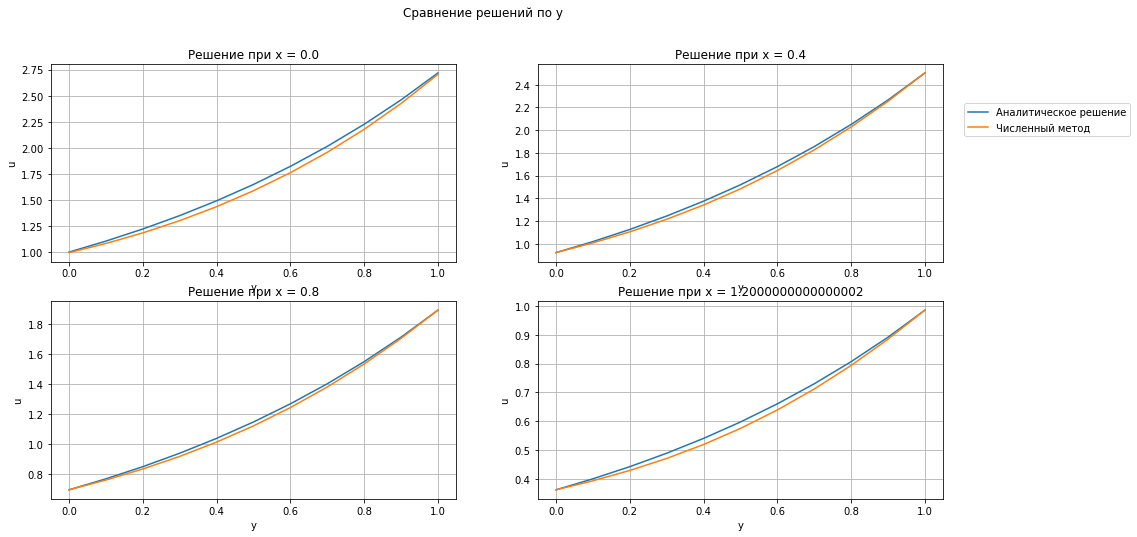

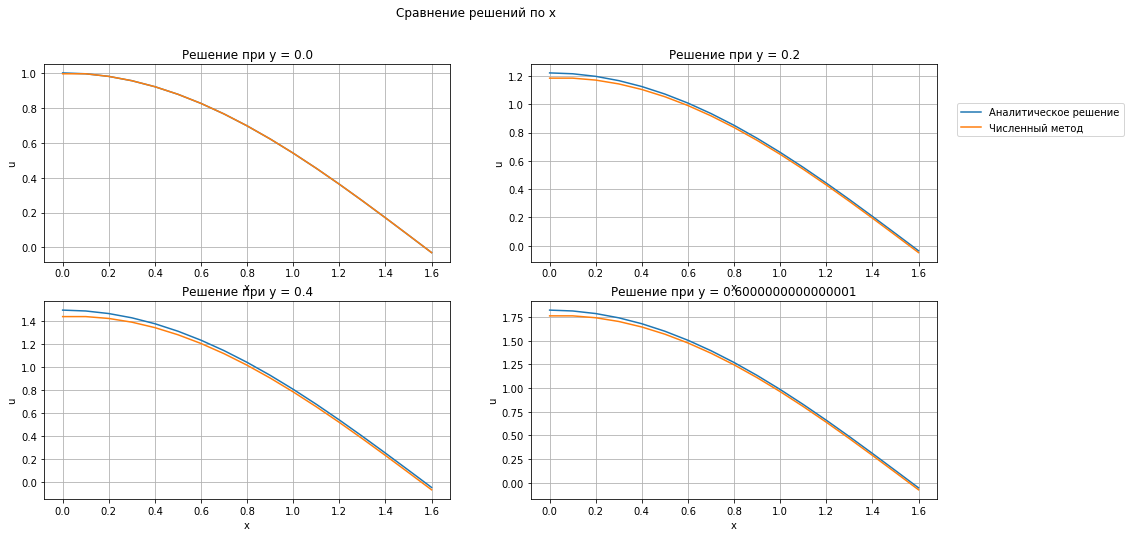

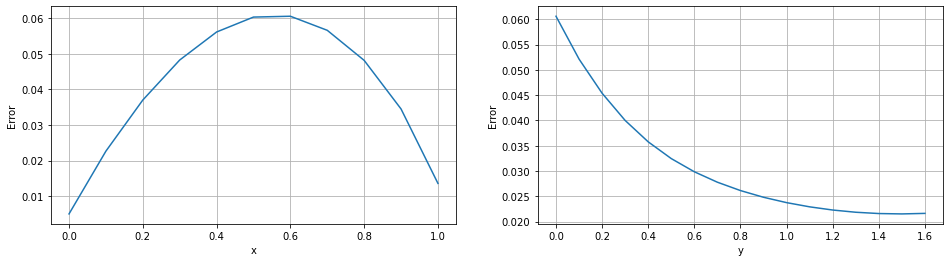

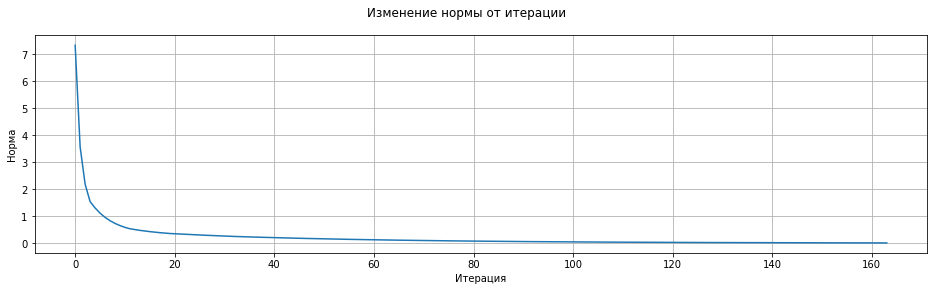

In [8]:
visualize('simple_iter', 0.1, 0.1, 0.01)

## Метод Зейделя

Iter count 99
Norma 0.009837860905913626
MSE 0.00027048240796567654
RMSE 0.016446349381114233


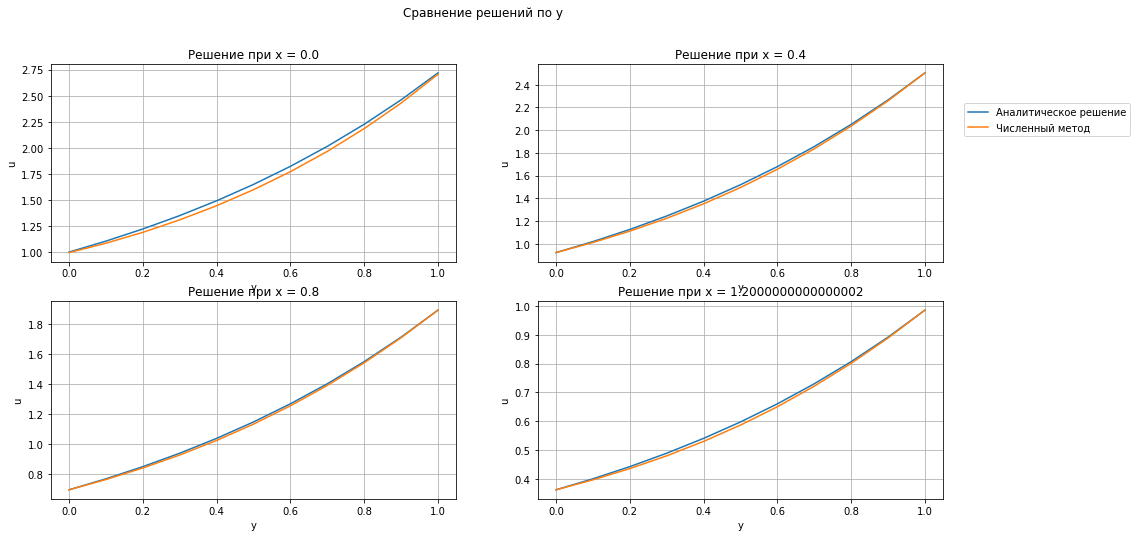

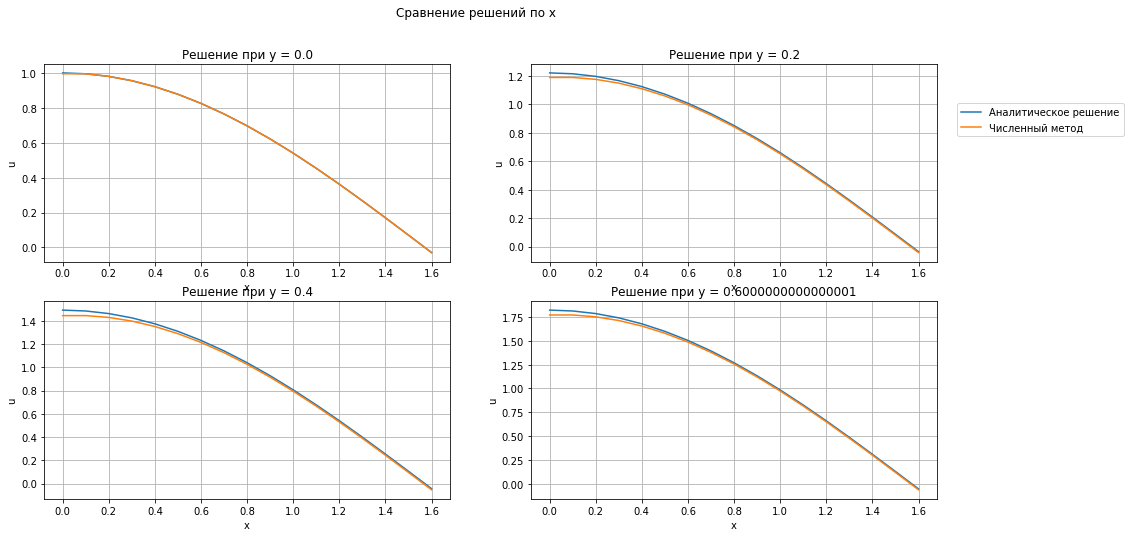

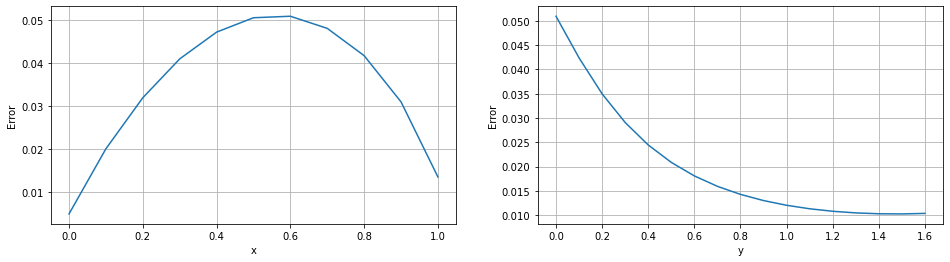

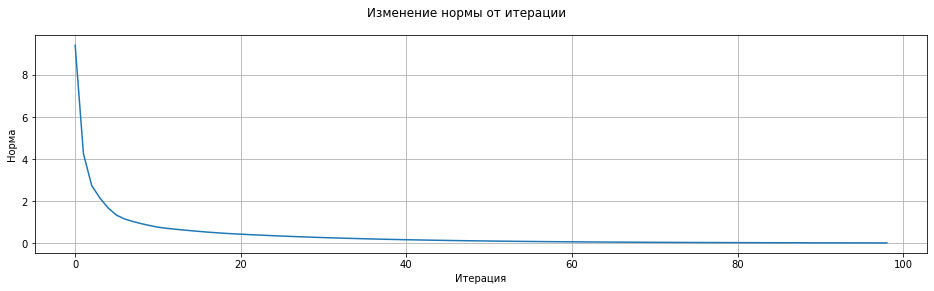

In [9]:
visualize('zeidel', 0.1, 0.1, 0.01)

## Метод простых итераций с релаксацией

Iter count 27
Norma 0.007483187345673742
MSE 9.269325409059549e-05
RMSE 0.009627733590549517


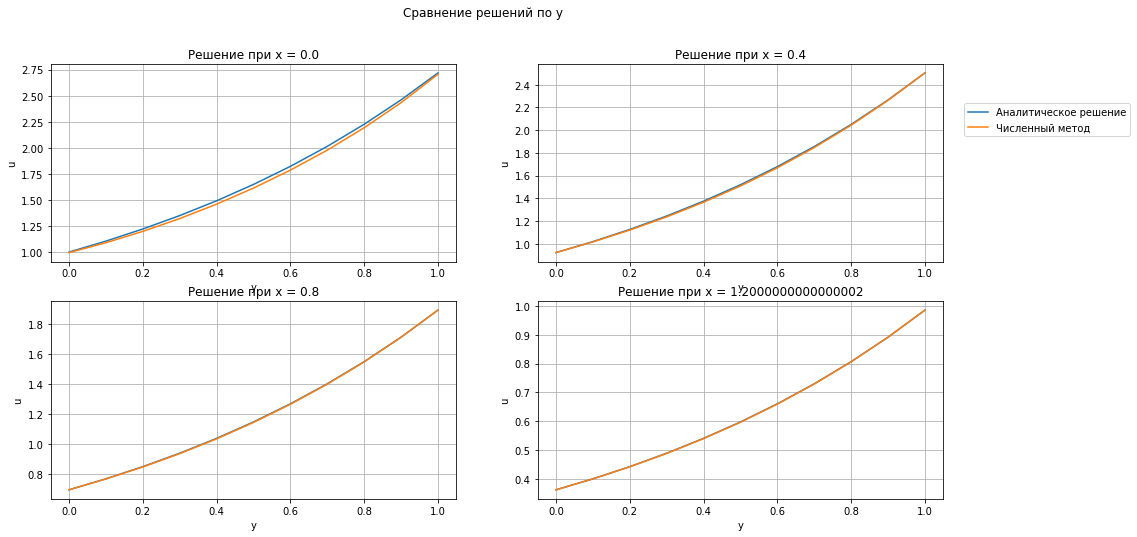

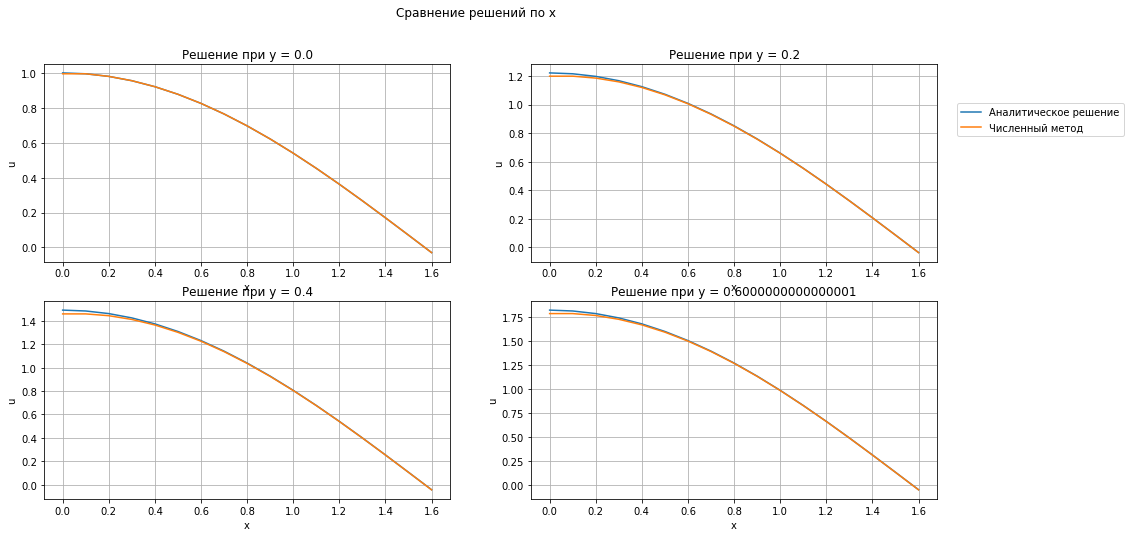

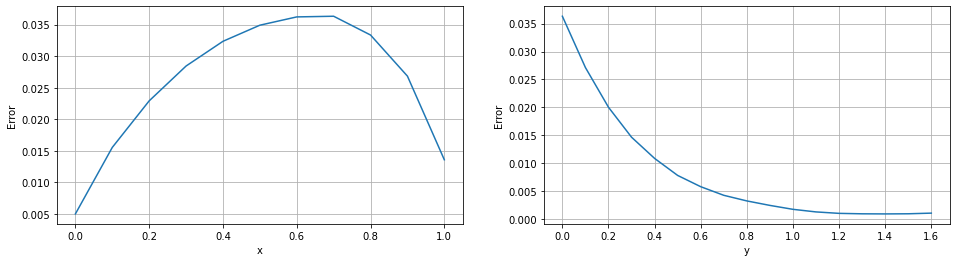

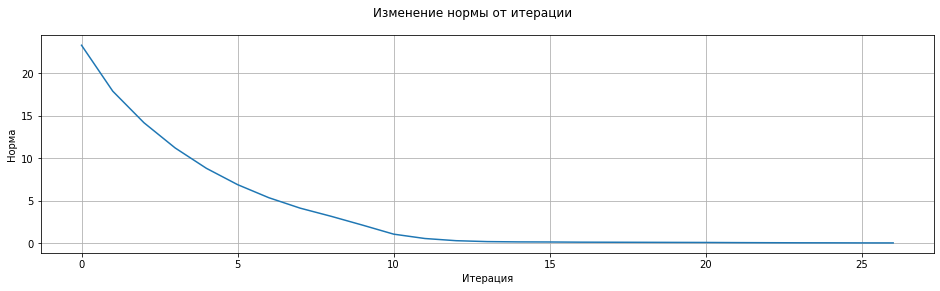

In [10]:
visualize('relax', 0.1, 0.1, 0.01)